In [1]:
import os

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
from epiweeks import Week
from datetime import datetime, timedelta
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
import numpy as np
from utils import timeseries_formatting, basic_formatting, dec_to_date, hpd, _toYearFraction
from dendropy import TreeList, Tree
import time
import seaborn as sns
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1 import make_axes_locatable

prop = mpl.font_manager.FontProperties('Roboto')
mpl.rcParams['font.sans-serif'] = prop.get_name()
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.size']=16

COLOR = '#343434'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

# Supplemental Figure 4: Sampling in San Diego and Baja California is proportion to cases.
We sampled a larged number of sequences in both San Diego and Baja California. Here we determine whether this sampling was consistented with reported cases in both locations.

We load in cases for San Diego County. These were retrieved from the Outbreak.info API as part of our analysis to infer infections. We use a 7-day rolling average of daily reported cases.

In [2]:
cases = pd.read_csv( "../analyses/estimated-importation-risk/back-calculated-infections.csv", usecols=["date", "location", "cases"], parse_dates=["date"] )
sd_cases = cases.loc[cases["location"]=="San Diego County"].copy()
sd_cases["date"] = pd.to_datetime( sd_cases["date"] )
sd_cases["week"] = sd_cases["date"].apply( lambda x: Week.fromdate(x).startdate() )
sd_cases.head()

,date,location,cases,week
253147,2020-01-20,San Diego County,0,2020-01-19
253148,2020-01-21,San Diego County,0,2020-01-19
253149,2020-01-22,San Diego County,0,2020-01-19
253150,2020-01-23,San Diego County,0,2020-01-19
253151,2020-01-24,San Diego County,0,2020-01-19


We load cases for Baja California. We found that data retrieved directed from the Mexican National Council for Science and Technology are the most complete.

In [3]:
bc_cases = pd.read_csv( "../data/cases_mexico.csv", index_col="nombre" )
bc_cases = bc_cases.drop( columns=["cve_ent", "poblacion"] )
bc_cases = bc_cases.T
bc_cases.index = pd.to_datetime( bc_cases.index, format="%d-%m-%Y" )
bc_cases = bc_cases["BAJA CALIFORNIA"].reset_index()
bc_cases.columns = ["date", "cases"]
bc_cases["week"] = bc_cases["date"].apply( lambda x: Week.fromdate(x).startdate() )
bc_cases.head()

,date,cases,week
0,2020-02-26,0,2020-02-23
1,2020-02-27,0,2020-02-23
2,2020-02-28,0,2020-02-23
3,2020-02-29,0,2020-02-23
4,2020-03-01,0,2020-03-01


For San Diego and Baja California, we count the number of sequences that are available on GISAID for each epidemiological week during the pandemic.

In [5]:
def get_location_sequences( entry ):
    return_df = entry.copy()
    return_df["week"] = return_df["date_collected"].apply( lambda x: Week.fromdate(x).startdate() )
    return_df = return_df.groupby( "week" )["strain"].agg( "count" )
    return_df.name = "sequences"
    return_df = return_df.reset_index()
    return_df["week"] = pd.to_datetime(return_df["week"])
    return return_df

md = pd.read_csv( "../data/gisaid_metadata.csv.gz", compression="gzip", usecols=["strain", "date_collected", "country", "division", "location"], parse_dates=["date_collected"] )
sd_seqs = get_location_sequences( md.loc[(md["division"]=="California")&(md["location"].str.startswith( "San Diego"))])
bc_seqs = get_location_sequences( md.loc[(md["division"]=="Baja California")] )
sd_seqs.head()

/var/folders/yk/ygy5y6t17g7gptxs3pqtrp240000gn/T/ipykernel_29866/809028264.py:10: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  md = pd.read_csv( "../data/gisaid_metadata.csv.gz", compression="gzip", usecols=["strain", "date_collected", "country", "division", "location"], parse_dates=["date_collected"] )


,week,sequences
0,2020-01-19,1
1,2020-01-26,3
2,2020-03-01,1
3,2020-03-08,29
4,2020-03-15,34


We plot the reported cases and collected sequences for both San Diego and Baja California. This generates Supplemental figure 4A-B

/var/folders/yk/ygy5y6t17g7gptxs3pqtrp240000gn/T/ipykernel_29866/119563758.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels )


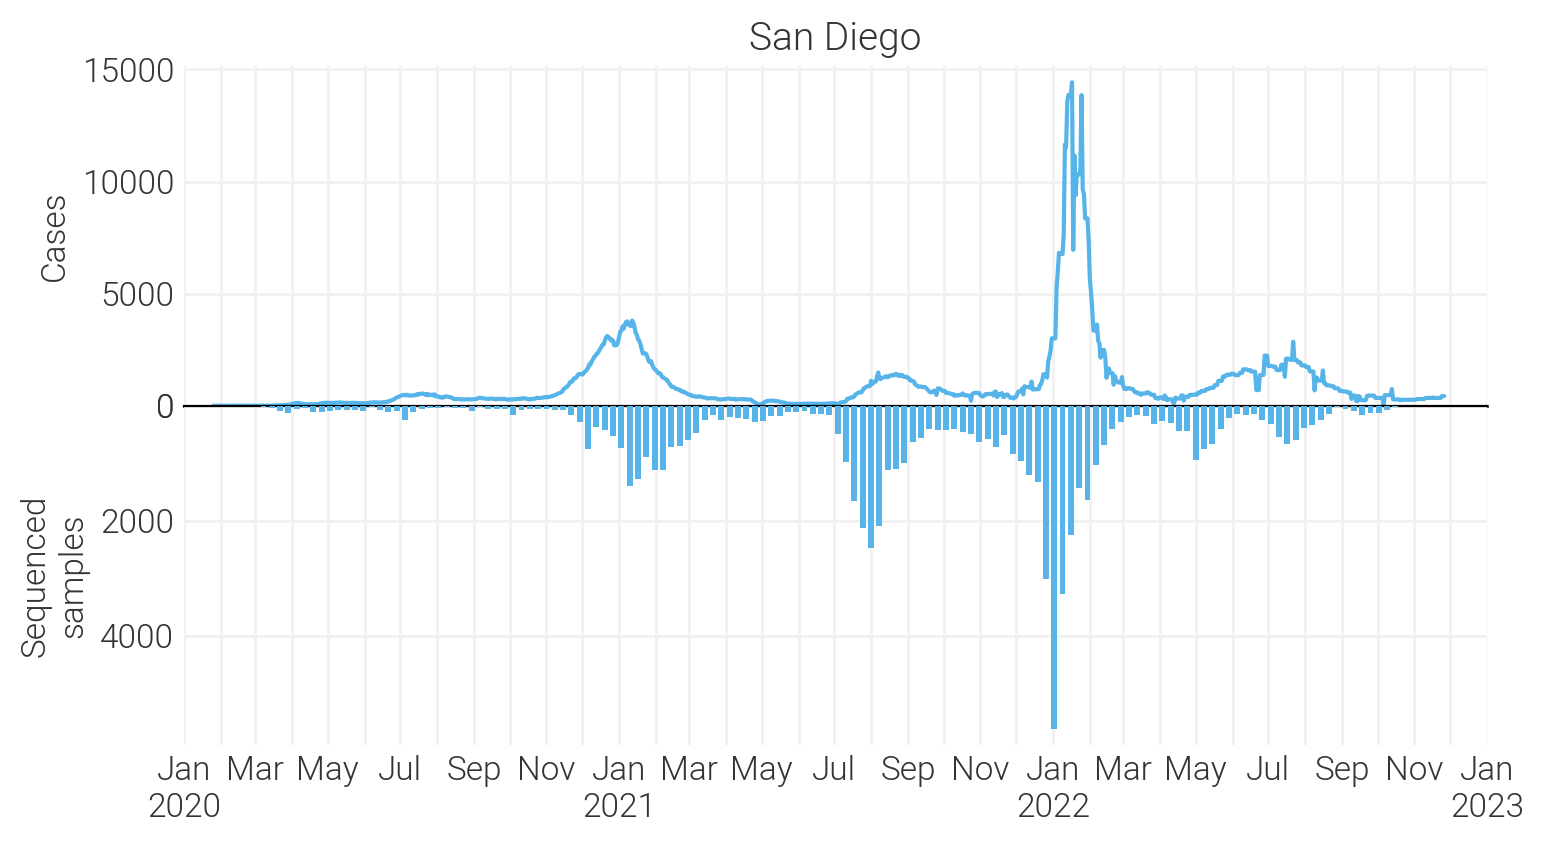

In [15]:
def new_timeseries_formatting( ax ):
    ax.xaxis.set_major_locator( mdates.MonthLocator() )
    formatter = mdates.DateFormatter( '%b' )
    long_formatter = mdates.DateFormatter( '%b\n%Y' )
    accepted_months = ["Jan", "Mar", "May", "Jul", "Sep", "Nov"]
    labels = []
    for date in ax.get_xticks():
        formatted_date = formatter.format_data( date )
        if formatted_date in accepted_months:
            if formatted_date == "Jan":
                labels.append( long_formatter.format_data(date) )
            else:
                labels.append( formatted_date )
        else:
            labels.append( "" )
    ax.set_xticklabels( labels )

    #ax.xaxis.set_minor_formatter( mdates.DateFormatter( '%b', usetex=True ) )
    #ax.xaxis.set_major_locator( mdates.YearLocator() )
    #ax.xaxis.set_major_formatter( mdates.DateFormatter( '%Y %b' ) )

def plot_cases_sequences( axis, case_df, sequences, title, color, fraction=False ):

    axis.plot( case_df["date"], case_df["cases"].rolling( 7 ).mean(), zorder=4, color=color, solid_capstyle="round" )

    divider = make_axes_locatable( ax )
    axis2 = divider.append_axes( "bottom", size="100%", pad=0, sharex=ax )

    if fraction:
        case_df["week"] = case_df["date"].apply( lambda x: Week.fromdate(x).startdate() )
        cases_weekly = case_df.groupby( "week" )["cases"].sum()
        cases_weekly.index = pd.to_datetime( cases_weekly.index )
        sequences = sequences.merge( cases_weekly, left_on="week", right_index=True )
        sequences["fraction"] = sequences["sequences"] / sequences["cases"]
        sequences = sequences.loc[sequences["fraction"]<1]
        axis2.bar( x=sequences["week"], height=sequences["fraction"], width=5, zorder=5, color=color )
    else:
        axis2.bar( x=sequences["week"], height=sequences["sequences"], width=5, zorder=5, color=color )

    axis2.invert_yaxis()

    date_range = ( pd.to_datetime( "2020-01-01" ), pd.to_datetime( "2023-01-01") )
    basic_formatting( axis, ylabel="Cases", which="both", xlims=date_range, ysize=12, xsize=12 )
    new_timeseries_formatting( ax )
    basic_formatting( axis2, ylabel="Sequenced\nsamples", which="both", spines=["top"], xlims=date_range, ysize=12, xsize=12 )
    new_timeseries_formatting( axis2 )

    axis.set_ylim( 0 )
    axis.spines["bottom"].set_visible(True)
    axis.spines["bottom"].set_color( COLOR )
    axis.spines["bottom"].set_linewidth( 1 )
    axis.spines["bottom"].set_zorder( 10 )

    axis.set_facecolor('white')
    axis2.set_facecolor( "white" )

    axis.tick_params( which="both", bottom=False, labelbottom=False )
    axis.set_title( title, fontsize=14, fontname="Roboto", fontweight=300 )

plt.figure( dpi=200, figsize=(8,4.5) )
ax = plt.subplot()
plot_cases_sequences( ax, cases.loc[cases["location"]=="San Diego County"], sd_seqs, "San Diego", color="#56B4E9", fraction=False )

plt.tight_layout()
plt.savefig( "../analyses/plots/figureS4_san-diego-sampling.pdf" )
plt.show()

/var/folders/yk/ygy5y6t17g7gptxs3pqtrp240000gn/T/ipykernel_29866/119563758.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( labels )


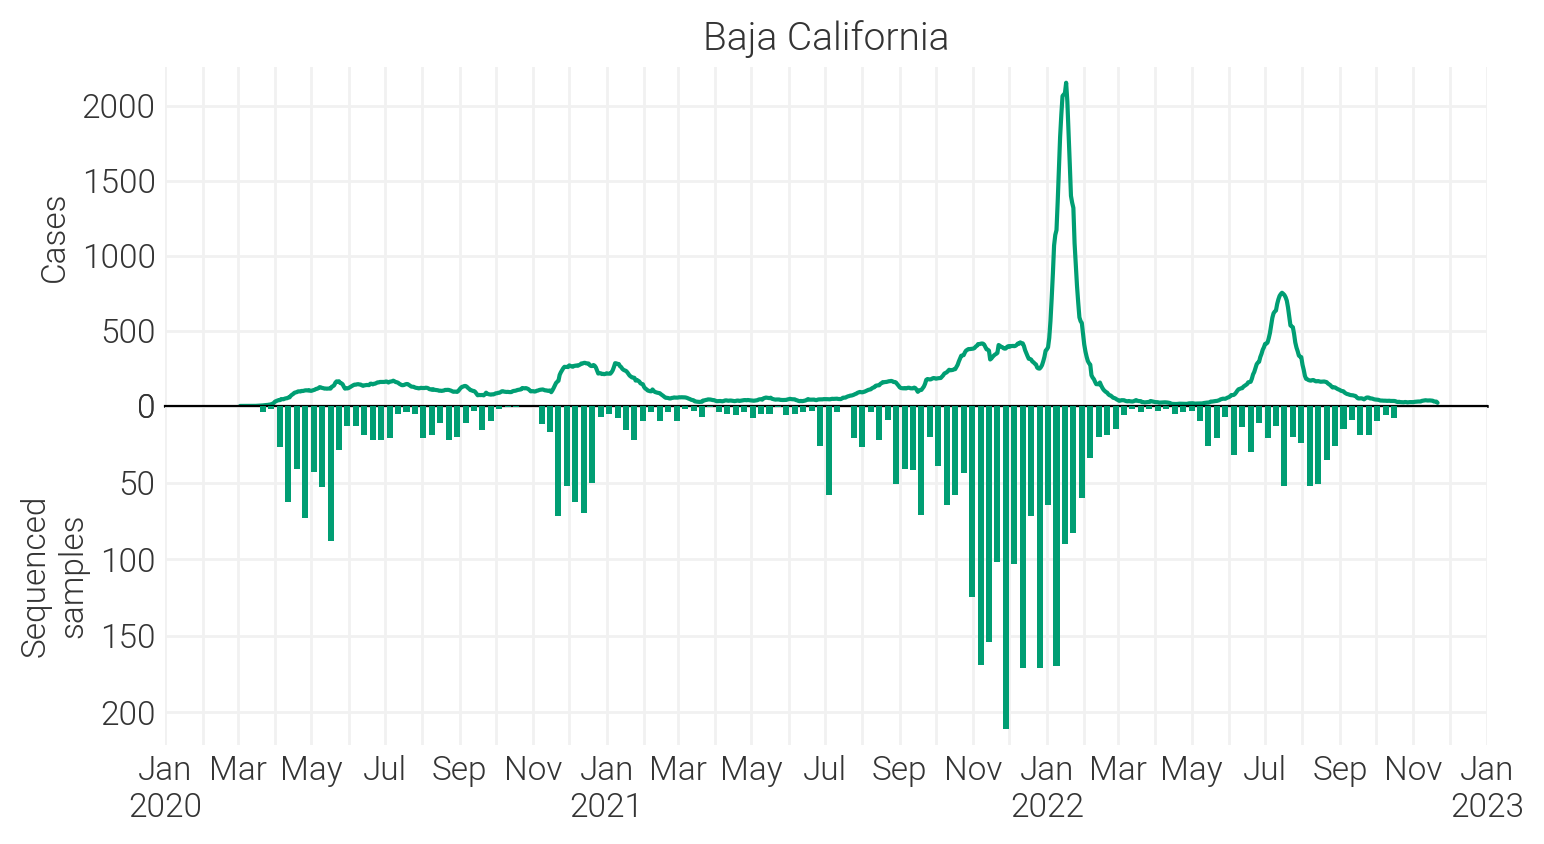

In [16]:
plt.figure( dpi=200, figsize=(8,4.5) )
ax = plt.subplot()
plot_cases_sequences( ax, bc_cases, bc_seqs, "Baja California", color="#009E73" )
plt.tight_layout()
plt.savefig( "../analyses/plots/figureS4_baja-california-sampling.pdf" )
plt.show()